In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/dog_breed/

Mounted at /content/drive
/content/drive/MyDrive/dog_breed


In [4]:
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16, EfficientNetB0
from multiprocessing import Pool, cpu_count
import cv2
from multiprocessing import Pool, cpu_count


In [5]:
annotations_dir = '/content/drive/MyDrive/dog_breed/archive/annotations/Annotation/'
image_dir = '/content/drive/MyDrive/dog_breed/archive/images/Images/'

breed_list = os.listdir(annotations_dir)
breed_list.sort()

label2index_all = {name: index for index, name in enumerate(breed_list)}
index2label_all = {index: name for index, name in enumerate(breed_list)}

images_all = []
annotations_all = []

for breed in breed_list:
    image_files = os.listdir(os.path.join(image_dir, breed))
    image_files.sort()
    breed_name = breed.split('-')[-1]
    images_all.extend([os.path.join(image_dir, breed, f) for f in image_files])
    annotations_all.extend([breed_name] * len(image_files))

print(f"Processed {len(images_all)} images.")

Processed 21157 images.


In [7]:
len(breed_list)

120

In [49]:
len(images_all)


21160

In [48]:
images_all

array(['/content/drive/MyDrive/dog_breed/archive/images/Images/n02085620-Chihuahua/n02085620_10074.jpg',
       '/content/drive/MyDrive/dog_breed/archive/images/Images/n02085620-Chihuahua/n02085620_10131.jpg',
       '/content/drive/MyDrive/dog_breed/archive/images/Images/n02085620-Chihuahua/n02085620_10621.jpg',
       ...,
       '/content/drive/MyDrive/dog_breed/archive/images/Images/n02116738-African_hunting_dog/n02116738_9829.jpg',
       '/content/drive/MyDrive/dog_breed/archive/images/Images/n02116738-African_hunting_dog/n02116738_9844.jpg',
       '/content/drive/MyDrive/dog_breed/archive/images/Images/n02116738-African_hunting_dog/n02116738_9924.jpg'],
      dtype='<U115')

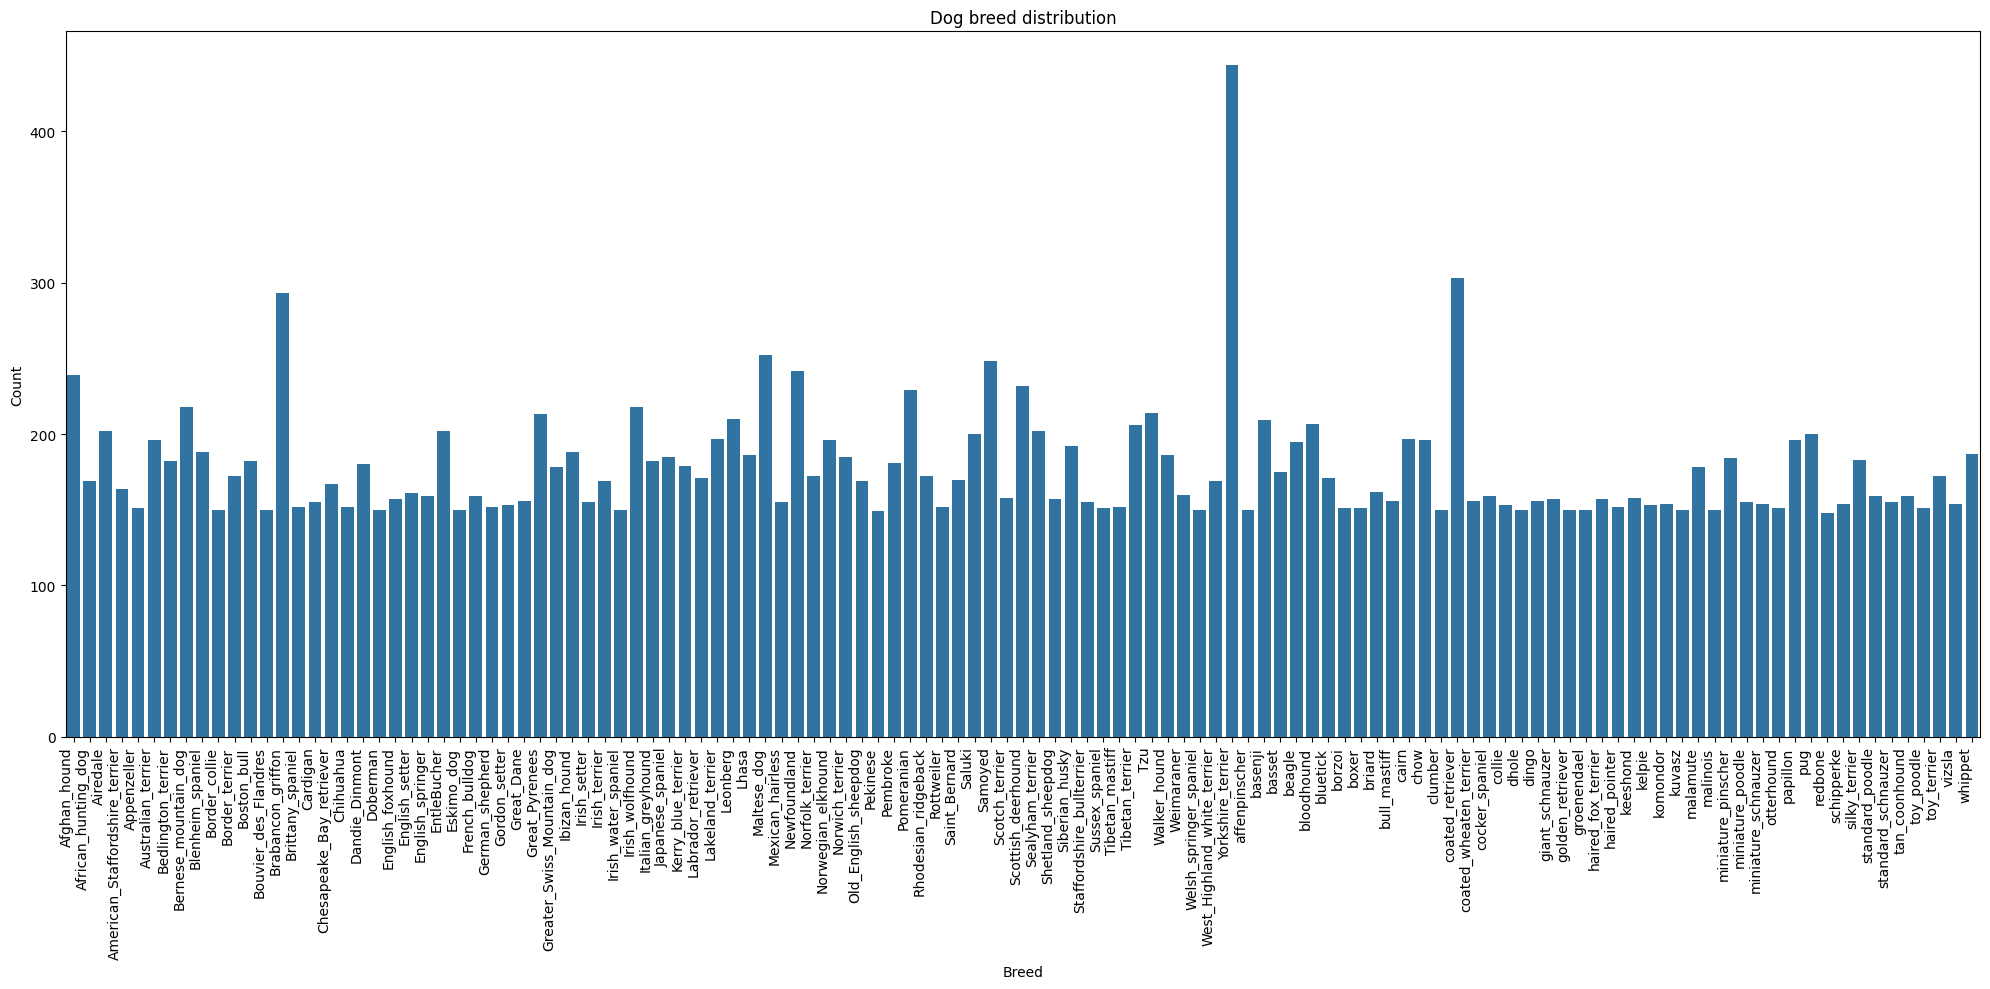

In [ ]:
unique_labels, label_counts = np.unique(annotations_all, return_counts=True)
plt.figure(figsize=(20, 10))
sns.barplot(x=unique_labels, y=label_counts)
plt.title('Dog breed distribution')
plt.xlabel('Breed')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

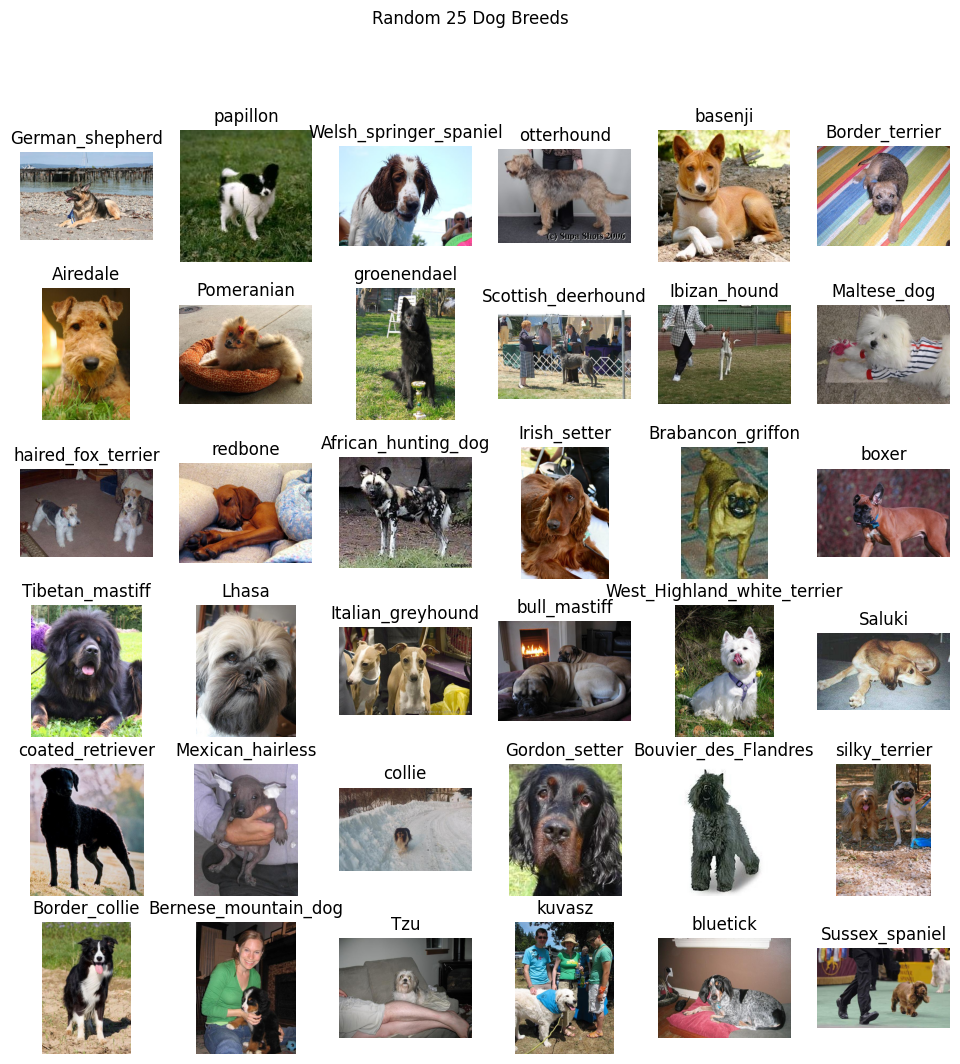

In [ ]:
import random

def get_unique_breeds(annotations):
    return list(set(annotations))

def get_random_image_path(breed, annotations, images):
    breed_images = [images[i] for i in range(len(images)) if annotations[i] == breed]
    return random.choice(breed_images)

unique_breeds = get_unique_breeds(annotations_all)

random_breeds = random.sample(unique_breeds, 36)

plt.figure(figsize=(12, 12))
for i, breed in enumerate(random_breeds):
    plt.subplot(6, 6, i+1)
    img_path = get_random_image_path(breed, annotations_all, images_all)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(breed.split('-')[-1])
    plt.axis('off')

plt.suptitle("Random 25 Dog Breeds")
plt.show()


In [6]:
def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    if h > w:
        new_h, new_w = target_size[0], int(w * target_size[0] / h)
    else:
        new_h, new_w = int(h * target_size[1] / w), target_size[1]

    img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    new_img = np.ones((target_size[0], target_size[1], 3), dtype=np.uint8) * 255
    y_offset = (target_size[0] - new_h) // 2
    x_offset = (target_size[1] - new_w) // 2
    new_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = img

    return new_img

In [7]:
def preprocess_images_parallel(image_paths, target_size=(150, 150)):
    with Pool(cpu_count()) as pool:
        final_images = pool.starmap(preprocess_image, [(image_path, target_size) for image_path in image_paths])
    return np.array(final_images)


In [8]:
final_images = preprocess_images_parallel(images_all)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(annotations_all)

print(f"Preprocessed {len(final_images)} images.")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Preprocessed 21157 images.


In [9]:
train_images = []
val_images = []
train_labels = []
val_labels = []

for breed in np.unique(encoded_labels):
    breed_indices = np.where(encoded_labels == breed)[0]
    train_idx, val_idx = train_test_split(breed_indices, test_size=0.2, random_state=42)
    train_images.extend(final_images[train_idx])
    val_images.extend(final_images[val_idx])
    train_labels.extend(encoded_labels[train_idx])
    val_labels.extend(encoded_labels[val_idx])

train_images = np.array(train_images)
val_images = np.array(val_images)
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

print(f"Training set: {len(train_images)} samples")
print(f"Validation set: {len(val_images)} samples")

Training set: 16879 samples
Validation set: 4278 samples


In [10]:
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2)

val_datagen = ImageDataGenerator()



In [11]:
train_generator = train_datagen.flow(
    train_images,
    tf.keras.utils.to_categorical(train_labels, num_classes=len(breed_list)),
    batch_size=32,
    shuffle=True)

val_generator = val_datagen.flow(
    val_images,
    tf.keras.utils.to_categorical(val_labels, num_classes=len(breed_list)),
    batch_size=32,
    shuffle=True)


In [24]:
def create_vgg16_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')])

    return model

input_shape = (200, 200, 3)
model = create_vgg16_model(input_shape, len(breed_list))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 global_average_pooling2d_6  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_19 (Dense)            (None, 1024)              525312    
                                                                 
 batch_normalization_13 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dropout_14 (Dropout)        (None, 1024)              0         
                                                                 
 dense_20 (Dense)            (None, 120)              

In [25]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator)


Epoch 1/20
528/528 [==============================] - 83s 154ms/step - loss: 3.8564 - accuracy: 0.1767 - val_loss: 2.8391 - val_accuracy: 0.3268
Epoch 2/20
528/528 [==============================] - 81s 154ms/step - loss: 3.0234 - accuracy: 0.2824 - val_loss: 2.5880 - val_accuracy: 0.3763
Epoch 3/20
528/528 [==============================] - 82s 155ms/step - loss: 2.8033 - accuracy: 0.3157 - val_loss: 2.4720 - val_accuracy: 0.3948
Epoch 4/20
528/528 [==============================] - 81s 153ms/step - loss: 2.6895 - accuracy: 0.3320 - val_loss: 2.3984 - val_accuracy: 0.4023
Epoch 5/20
528/528 [==============================] - 81s 154ms/step - loss: 2.5848 - accuracy: 0.3519 - val_loss: 2.4005 - val_accuracy: 0.4137
Epoch 6/20
528/528 [==============================] - 81s 153ms/step - loss: 2.4994 - accuracy: 0.3631 - val_loss: 2.3707 - val_accuracy: 0.4088
Epoch 7/20
528/528 [==============================] - 82s 154ms/step - loss: 2.4653 - accuracy: 0.3678 - val_loss: 2.3536 - val_ac

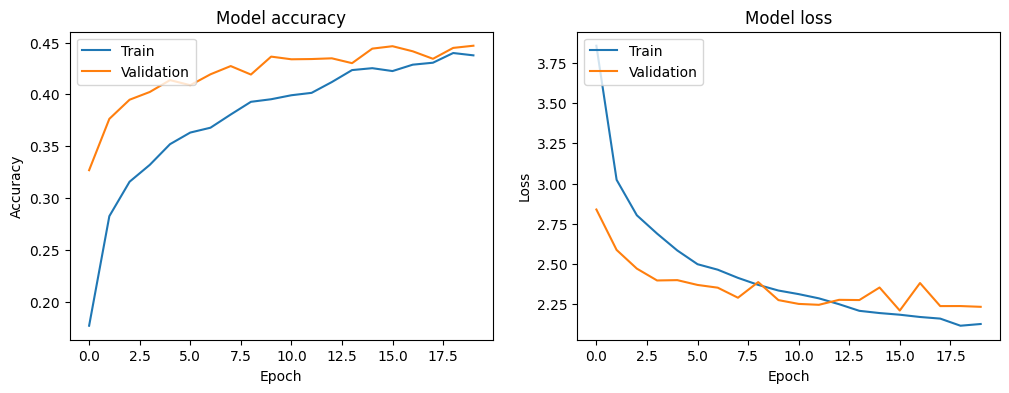

In [26]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [41]:
def create_efficientnet_model(input_shape, num_classes,  trainable_layers=10):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    for layer in base_model.layers[-trainable_layers:]:
        layer.trainable = True

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

input_shape = (200, 200, 3)
model2 = create_efficientnet_model(input_shape=input_shape, num_classes=len(breed_list))

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
 1 (GlobalAveragePooling2D)                                      
                                                                 
 dense_30 (Dense)            (None, 1024)              1311744   
                                                                 
 batch_normalization_19 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dropout_20 (Dropout)        (None, 1024)              0         
                                                     

In [42]:
history2 = model2.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator)

Epoch 1/20
528/528 [==============================] - 91s 159ms/step - loss: 2.6125 - accuracy: 0.3727 - val_loss: 1.3031 - val_accuracy: 0.6323
Epoch 2/20
528/528 [==============================] - 81s 154ms/step - loss: 1.9163 - accuracy: 0.5001 - val_loss: 1.2241 - val_accuracy: 0.6417
Epoch 3/20
528/528 [==============================] - 82s 155ms/step - loss: 1.7337 - accuracy: 0.5330 - val_loss: 1.1346 - val_accuracy: 0.6683
Epoch 4/20
528/528 [==============================] - 82s 156ms/step - loss: 1.6311 - accuracy: 0.5488 - val_loss: 1.1344 - val_accuracy: 0.6706
Epoch 5/20
528/528 [==============================] - 82s 154ms/step - loss: 1.5785 - accuracy: 0.5651 - val_loss: 1.1260 - val_accuracy: 0.6772
Epoch 6/20
528/528 [==============================] - 82s 156ms/step - loss: 1.5212 - accuracy: 0.5739 - val_loss: 1.1059 - val_accuracy: 0.6746
Epoch 7/20
528/528 [==============================] - 82s 155ms/step - loss: 1.4745 - accuracy: 0.5855 - val_loss: 1.0864 - val_ac

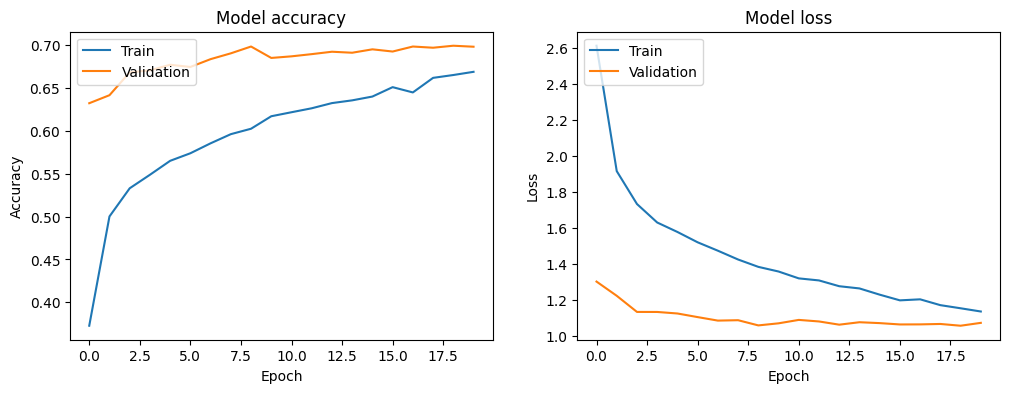

In [43]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()